- **Author：** 马肖
- **E-Mail：** maxiaoscut@aliyun.com
- **GitHub：**  https://github.com/Albertsr

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style('whitegrid')
sns.set(font_scale=1.2, style='ticks', palette='Set2') 
%matplotlib inline

In [2]:
train = pd.read_csv("DEA.csv")
train.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S


## 1 对离散型特征的探索（以Pclass为例）

### 1.1 各等级舱位等级的人数

In [3]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

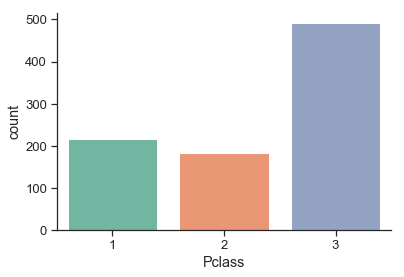

In [4]:
sns.countplot(x='Pclass', data=train)
sns.despine()

#### 结论：三等舱人人数最多，二等舱人数最少

### 1.2 船舱等级对生还率的影响

In [5]:
train.pivot_table(index=["Pclass"], values=["Survived"], aggfunc="mean")
# 等价于train.groupby(["Embarked"])["Survived"].mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


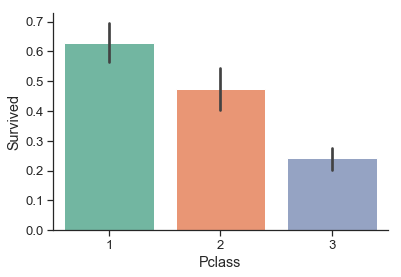

In [6]:
sns.barplot(x='Pclass', y='Survived', data=train)
sns.despine()

#### 结论：一等舱乘客有最高的生还率

### 1.3 与其他离散型变量的联合探索

#### 1.3.1  对Pclass、Sex联合探索：无论哪个船舱等级，女性都有更高的生还率

In [7]:
train.pivot_table(index=["Pclass"], values=["Survived"], columns=["Sex"])

Survived          
Sex       female      male
Pclass                    
1       0.968085  0.368852
2       0.921053  0.157407
3       0.500000  0.135447

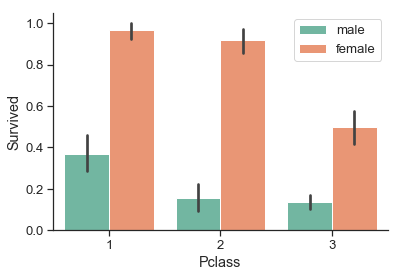

In [8]:
sns.barplot(x='Pclass', y='Survived', data=train, hue='Sex', dodge=True)  # hue_order=['female','male']
sns.despine()
plt.legend()

#### 1.3.2 不同性别对应的不同舱位均值 : 男性乘客的平均舱位稍高于女性乘客

In [9]:
train.pivot_table(index=["Sex"], values=["Pclass"])

,Pclass
Sex,
female,2.159236
male,2.389948


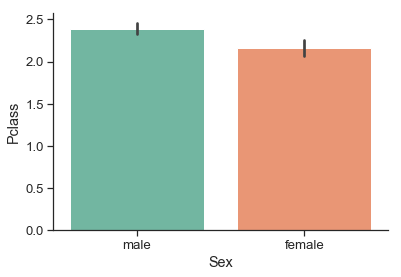

In [10]:
sns.barplot(x='Sex', y='Pclass', data=train) 
sns.despine()

#### 1.3.3 对Pclass、Embarked进行联合探索：S港口登录的乘客生还率最低，C港口登录的乘客生还率稍高于Q

In [11]:
train.pivot_table(index=["Pclass"], values=["Survived"], columns=["Embarked"])

Survived                    
Embarked         C         Q         S
Pclass                                
1         0.694118  0.500000  0.589147
2         0.529412  0.666667  0.463415
3         0.378788  0.375000  0.189802

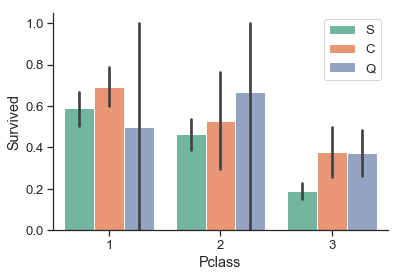

In [12]:
sns.barplot(x='Pclass', y='Survived', data=train, hue='Embarked', dodge=True)  # hue_order=['female','male']
sns.despine()
plt.legend()

### 1.4 与其他连续性变量的联合探索

#### 结论1：无论什么性别，舱位与年龄成反比；无论哪个舱位，男性要年长于女性

In [13]:
train.pivot_table(index=["Pclass"], values=["Age", 'Fare'], columns=["Sex"])

Age                   Fare           
Sex        female       male      female       male
Pclass                                             
1       34.768107  41.711241  106.125798  67.226127
2       28.744443  30.955625   21.970121  19.741782
3       21.973566  26.707903   16.118810  12.661633

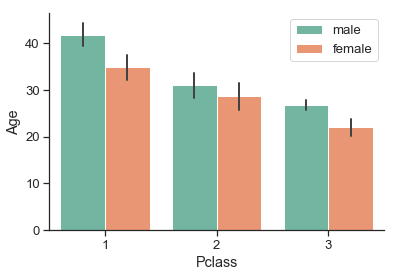

In [14]:
sns.barplot(x='Pclass', y='Age', data=train, hue="Sex", dodge=True, errwidth=2)  # hue_order=['female','male']
sns.despine()
plt.legend(loc=1)

#### 结论2：舱位与票价成正比；无论哪个舱位，女性支付的费用都高于男性

In [15]:
train.pivot_table(index=["Pclass"], values=["Fare"], columns=["Sex"])

Fare           
Sex         female       male
Pclass                       
1       106.125798  67.226127
2        21.970121  19.741782
3        16.118810  12.661633

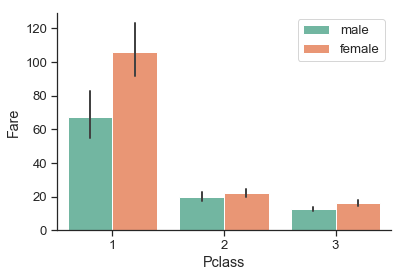

In [16]:
sns.barplot(x='Pclass', y='Fare', data=train, hue="Sex", dodge=True, errwidth=2)  # hue_order=['female','male']
sns.despine()
plt.legend(loc=1)

### 将图表予以整合

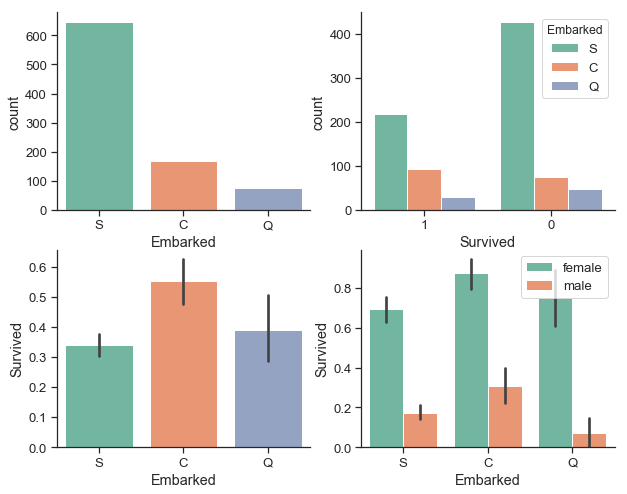

In [17]:
sns.set(font_scale=1.2,style='ticks',palette='Set2') 
f, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.despine()


#特征的不同取值对应的样本数量
sns.countplot(x='Embarked', data=train, ax=axes[0, 0])

#特征Embarked的不同取值对应于不同的类标的数量
sns.countplot(x='Survived', hue="Embarked", data=train, order=[1,0], ax=axes[0, 1])

#特征的不同取值对应的生还概率
sns.barplot(x='Embarked', y='Survived',data=train, dodge=True, ax=axes[1, 0])    #order=['S','C','Q']


# 联合其他特征Sex共同取各种类别的概率
# dodge=True表示不同性别予以分开展示，否则为堆叠展示
sns.barplot(x='Embarked', y='Survived',data=train, hue='Sex',hue_order=['female','male'], dodge=True, ax=axes[1, 1]) 
plt.legend(loc='upper right')

## 2 对连续型特征进行探索

### 2.1 直方图、KDE曲线、箱型图

#### 通过箱型图发现Fare特征存在一些极端的异常值，对这些特征修改为95分位点的值

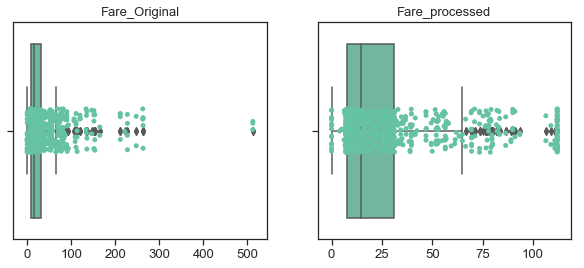

In [18]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(train["Fare"], ax=axes[0])
sns.stripplot(train["Fare"], jitter=True, ax=axes[0])
axes[0].set_title("Fare_Original", fontsize=13)
axes[0].set_xlabel('')

Fare_per_95 = np.percentile(train["Fare"], 95)
train["Fare"][train["Fare"] >= Fare_per_95] = Fare_per_95
sns.boxplot(train["Fare"], ax=axes[1])
sns.stripplot(train["Fare"], jitter=True, ax=axes[1])
axes[1].set_title("Fare_processed", fontsize=13)
axes[1].set_xlabel('')
plt.show()

Text(0.5,0,'')

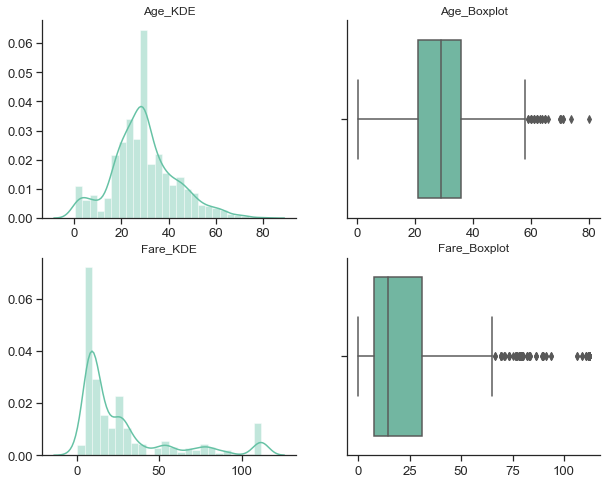

In [19]:
sns.set(font_scale=1.2,style='ticks',palette='Set2') 
f, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.despine()


#特征的不同取值对应的样本数量
sns.distplot(train['Age'], ax=axes[0,0])
axes[0,0].set_title("Age_KDE", fontsize=12)
axes[0,0].set_xlabel("")

sns.boxplot(train['Age'], ax=axes[0,1])
axes[0,1].set_title("Age_Boxplot", fontsize=12)
axes[0,1].set_xlabel("")

#特征Embarked的不同取值对应于不同的类标的数量
sns.distplot(train['Fare'], ax=axes[1,0])
axes[1,0].set_title("Fare_KDE", fontsize=12)
axes[1,0].set_xlabel("")

sns.boxplot(train['Fare'], ax=axes[1,1])
axes[1,1].set_title("Fare_Boxplot", fontsize=12)
axes[1,1].set_xlabel("")

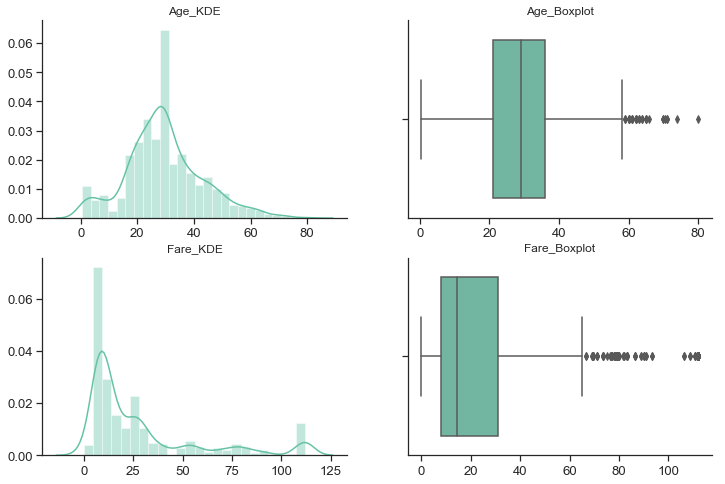

In [20]:
fig = plt.figure(figsize=(12,8))

sns.distplot(train['Age'], ax=plt.subplot(221))
plt.title("Age_KDE", fontsize=12)
plt.xlabel('')


sns.boxplot(train['Age'], ax=plt.subplot(222))
plt.title("Age_Boxplot", fontsize=12)
plt.xlabel('')


sns.distplot(train['Fare'], ax=plt.subplot(223))
plt.title("Fare_KDE", fontsize=12)
plt.xlabel('')


sns.boxplot(train['Fare'], ax=plt.subplot(224))
plt.title("Fare_Boxplot", fontsize=12)
plt.xlabel('')

sns.despine()

### 2.2 不同分类结果对应的连续型变量的KDE曲线

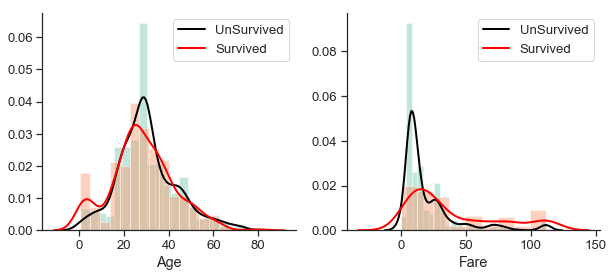

In [21]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.distplot(train['Age'][train['Survived']==0], kde_kws={"color": "k", "lw": 2, "label": "UnSurvived"}, ax=axes[0])
sns.distplot(train['Age'][train['Survived']==1], kde_kws={"color": "r", "lw": 2, "label": "Survived"}, ax=axes[0])

sns.distplot(train['Fare'][train['Survived']==0],kde_kws={"color": "k", "lw": 2, "label": "UnSurvived"}, ax=axes[1])
sns.distplot(train['Fare'][train['Survived']==1],kde_kws={"color": "r", "lw": 2, "label": "Survived"}, ax=axes[1])

sns.despine()

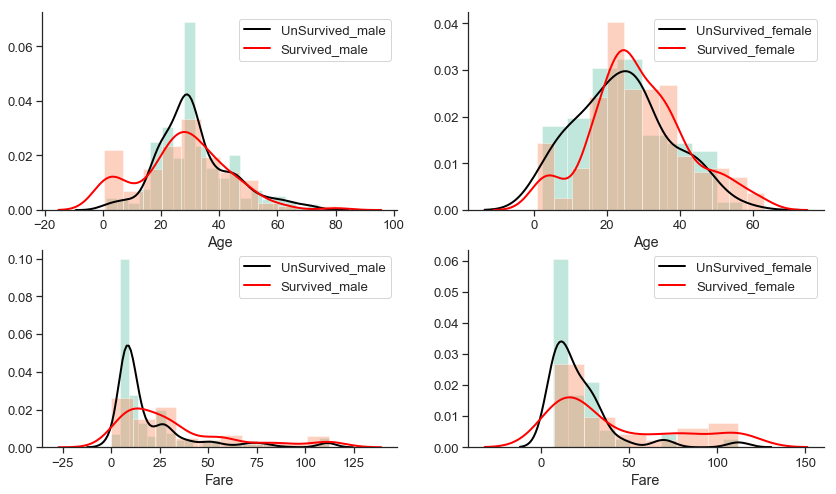

In [22]:
f, axes = plt.subplots(2, 2, figsize=(14, 8))

sns.distplot(train['Age'][(train['Survived']==0) & (train['Sex']=="male")], 
             kde_kws={"color": "k", "lw": 2, "label": "UnSurvived_male"}, ax=axes[0, 0])

sns.distplot(train['Age'][(train['Survived']==1) & (train['Sex']=="male")], 
             kde_kws={"color": "r", "lw": 2, "label": "Survived_male"}, ax=axes[0, 0])



sns.distplot(train['Age'][(train['Survived']==0) & (train['Sex']=="female")], 
             kde_kws={"color": "k", "lw": 2, "label": "UnSurvived_female"}, ax=axes[0, 1])

sns.distplot(train['Age'][(train['Survived']==1) & (train['Sex']=="female")], 
             kde_kws={"color": "r", "lw": 2, "label": "Survived_female"}, ax=axes[0, 1])

# Fare
sns.distplot(train['Fare'][(train['Survived']==0) & (train['Sex']=="male")], 
             kde_kws={"color": "k", "lw": 2, "label": "UnSurvived_male"}, ax=axes[1, 0])

sns.distplot(train['Fare'][(train['Survived']==1) & (train['Sex']=="male")], 
             kde_kws={"color": "r", "lw": 2, "label": "Survived_male"}, ax=axes[1, 0])


sns.distplot(train['Fare'][(train['Survived']==0) & (train['Sex']=="female")], 
             kde_kws={"color": "k", "lw": 2, "label": "UnSurvived_female"}, ax=axes[1, 1])

sns.distplot(train['Fare'][(train['Survived']==1) & (train['Sex']=="female")], 
             kde_kws={"color": "r", "lw": 2, "label": "Survived_female"}, ax=axes[1, 1])

sns.despine()

#### 结论：
1.生还的人，无论什么性别，平均来看，支付了更高的费用，也比较年长


2.可以利用KDE曲线对Fare/Age做离散化处理

### 2.3 与其他的特征的联合探索

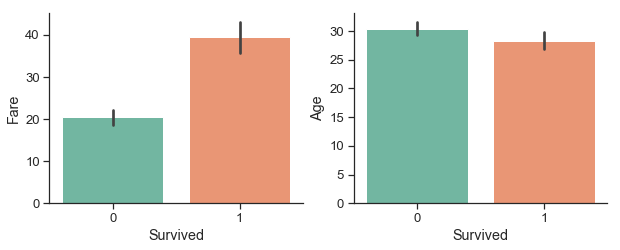

In [23]:
f, axes = plt.subplots(1, 2, figsize=(10, 3.5))
sns.barplot(x=train["Survived"], y=train["Fare"], ax=axes[0])
sns.barplot(x=train["Survived"], y=train["Age"], ax=axes[1])
sns.despine()

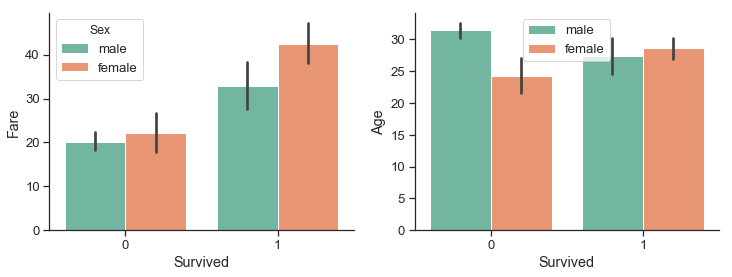

In [24]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(x=train["Survived"], y=train["Fare"], hue=train["Sex"], ax=axes[0])
sns.barplot(x=train["Survived"], y=train["Age"], hue=train["Sex"], ax=axes[1])

plt.legend()
sns.despine()

### 3 SibSp	Parch 这些特征虽然是连续型变量，但是取值较少，分布不均匀，可作为离散型变量处理

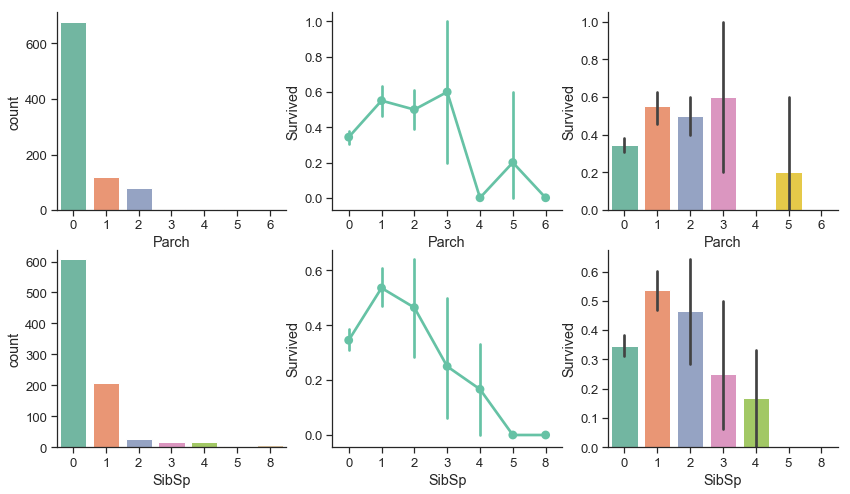

In [25]:
f, axes = plt.subplots(2, 3, figsize=(14, 8))
sns.countplot(x=train["Parch"], ax=axes[0,0])
sns.pointplot(x="Parch", y="Survived", data=train, ax=axes[0,1])
sns.barplot(x="Parch", y="Survived", data=train, ax=axes[0,2])

sns.countplot(x=train["SibSp"], ax=axes[1,0])
sns.pointplot(x="SibSp", y="Survived", data=train, ax=axes[1,1])
sns.barplot(x="SibSp", y="Survived", data=train, ax=axes[1,2])

sns.despine()